In [1]:
"""
Written by: Tommy Banker (thomas_banker@berkeley.edu)
"""

import os
import json
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from utils import *




matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            'figure.dpi' : 300,

                            })

font = {'weight' : 'bold',
        'size'   : 34}
plt.rc('font', **font)





In [2]:
methods = ['lipophilicity', ]
best_list = {'cep': 11.086613 }
best = 0#4.5#best_list['cep']
seeds = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,]


In [15]:
sample_configs = [r'./config/lipo/lipophilicity_SAAS_0.json',
                 r'./config/lipo/lipophilicity_GP_full_0.json',
                 r'./config/lipo/lipophilicity_GP_pca_0.json',
                 r'./config/lipo/lipophilicity_linear_0.json',
                 r'./config/lipo/lipophilicity_Random_0.json']


names = ['SAAS','GP_full','GP_PCA', 'Linear' ,'random']
names2 = ['MolDAIS','SGP',"SGP-PCA", 'SLR' ,'Random']

Res_dict_raw = {'SAAS':[], 'GP_full':[],'GP_PCA':[],'Linear':[] , 'random':[]}        
Res_dict_stat = {'SAAS':[], 'GP_full':[],'GP_PCA':[],'Linear':[] , 'random':[]}               
Smi_dict_stat = {'SAAS':[], 'GP_full':[],'GP_PCA':[],'Linear':[] , 'random':[]}                  


end = -1

for i100,sample_config in enumerate(sample_configs):        
    with open(sample_config) as f:
        exp_config = json.load(f)
    ########    
    y_variable = exp_config['common']['y_variable']
    max_min = exp_config['common']['max_min']
    init_budget = exp_config['common']['init_budget']
    total_budget = exp_config['common']['total_budget'] 
    bo_iters = np.arange(1, total_budget - init_budget + 1)
    ########
    all_results = np.zeros((len(methods), len(seeds), total_budget))
    smi_results = []
    sorted_results = np.zeros((len(methods), len(seeds), total_budget - init_budget + 1))
    conv_results = np.zeros((len(methods), (total_budget - init_budget + 1), 2))
    ########
    for i, method in enumerate(methods):
        for j, seed in enumerate(seeds):
            exp_config['exp_name'] = method #+ '_' + str(seed) 
            exp_config['seed'] = seed
            path = os.path.join('../results/', 'lipophilicity',)
            if i100==3 : 
                filename = f'lipophilicity_max_activity_Linear_seed_{seed}_bo-iter_90_10_to_100_samples_None_None_None'
            #elif i100=4 :
                
            else: 
                filename = get_filename(bo_iters[-1], exp_config)
            result = torch.load(os.path.join(path, filename + '.pkl'))
            all_results[i,j,:] = result['y_train'].squeeze()
            smi_results.append( result['smiles_train'])
    ########
    sorted_results[:,:,0] = np.max(all_results[:,:,:init_budget], axis=2)
    for i, method in enumerate(methods):
        for j, seed in enumerate(seeds):
            for sample in np.arange(total_budget - init_budget + end):
                if all_results[i,j,(init_budget + sample)] > sorted_results[i,j,sample]:
                    sorted_results[i,j,(sample + 1)] = all_results[i,j,(init_budget + sample)]
                else:
                    sorted_results[i,j,(sample + 1)] = sorted_results[i,j,(sample)]
    ########
    for i, method in enumerate(methods):
        for sample in np.arange(total_budget - init_budget + 1+ end):
            conv_results[i,sample,0] = np.mean(sorted_results[i,:,sample])
            conv_results[i,sample,1] = np.std(sorted_results[i,:,sample])
    ########
    sample_numbers = np.arange(total_budget - init_budget + 1)
    #max_min_vars = torch.load('../prop_data/max_min_vars.pkl')
    if max_min == 'max':
        conv_results[:,:,0] = conv_results[:,:,0]#(conv_results[:,:,0]- best  )*-1  #- max_min_vars[y_variable]['max']) * -1
    else:   # convention appears strange bc results as stored are already the
            # negative of the true values to perform minimization experiments
        conv_results[:,:,0] = (conv_results[:,:,0] - -1 * max_min_vars[y_variable]['min']) * -1
    
    
    Res_dict_raw[names[i100]] = sorted_results
    Res_dict_stat[names[i100]] = conv_results    
    Smi_dict_stat[names[i100]] = smi_results

In [16]:
Res_dict_raw['SAAS']

import pickle 

with open('./DataFiles/lipo_results.pkl', 'wb') as f:
    pickle.dump(Res_dict_raw, f)

/tmp/ipykernel_709790/1355287026.py:11: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(sample_numbers[:end], conv_results[0,:end,0], style, linewidth=3, label=names2[i], c=colors[i])


"    \n#sorted_results\nfig = plt.figure(figsize=(12,9))\nfor i, method in enumerate(names):\n    \n    style = '-'\n    sorted_results = Res_dict_raw[method]\n    plt.plot(sample_numbers, -1*sorted_results.squeeze(0).T+best, style, linewidth=3, label=method, c=colors[i])\n    #plt.fill_between(sample_numbers, conv_results[i,:,0]-(1.95*conv_results[i,:,1]/(len(seeds)**0.5)), conv_results[i,:,0]+(1.95*conv_results[i,:,1]/(len(seeds)**0.5)), alpha=0.1, color=colors[i])\n    #plt.title('Convergence Results Across ' + str(len(seeds)) + ' Runs with ' + str(init_budget) + ' Initial Random Samples')\nplt.xlabel('Iterations')\nplt.ylabel('Regret' )\n#plt.yscale('log')\nplt.ylim(0,1)    \nplt.xlim(0,90+end)   "

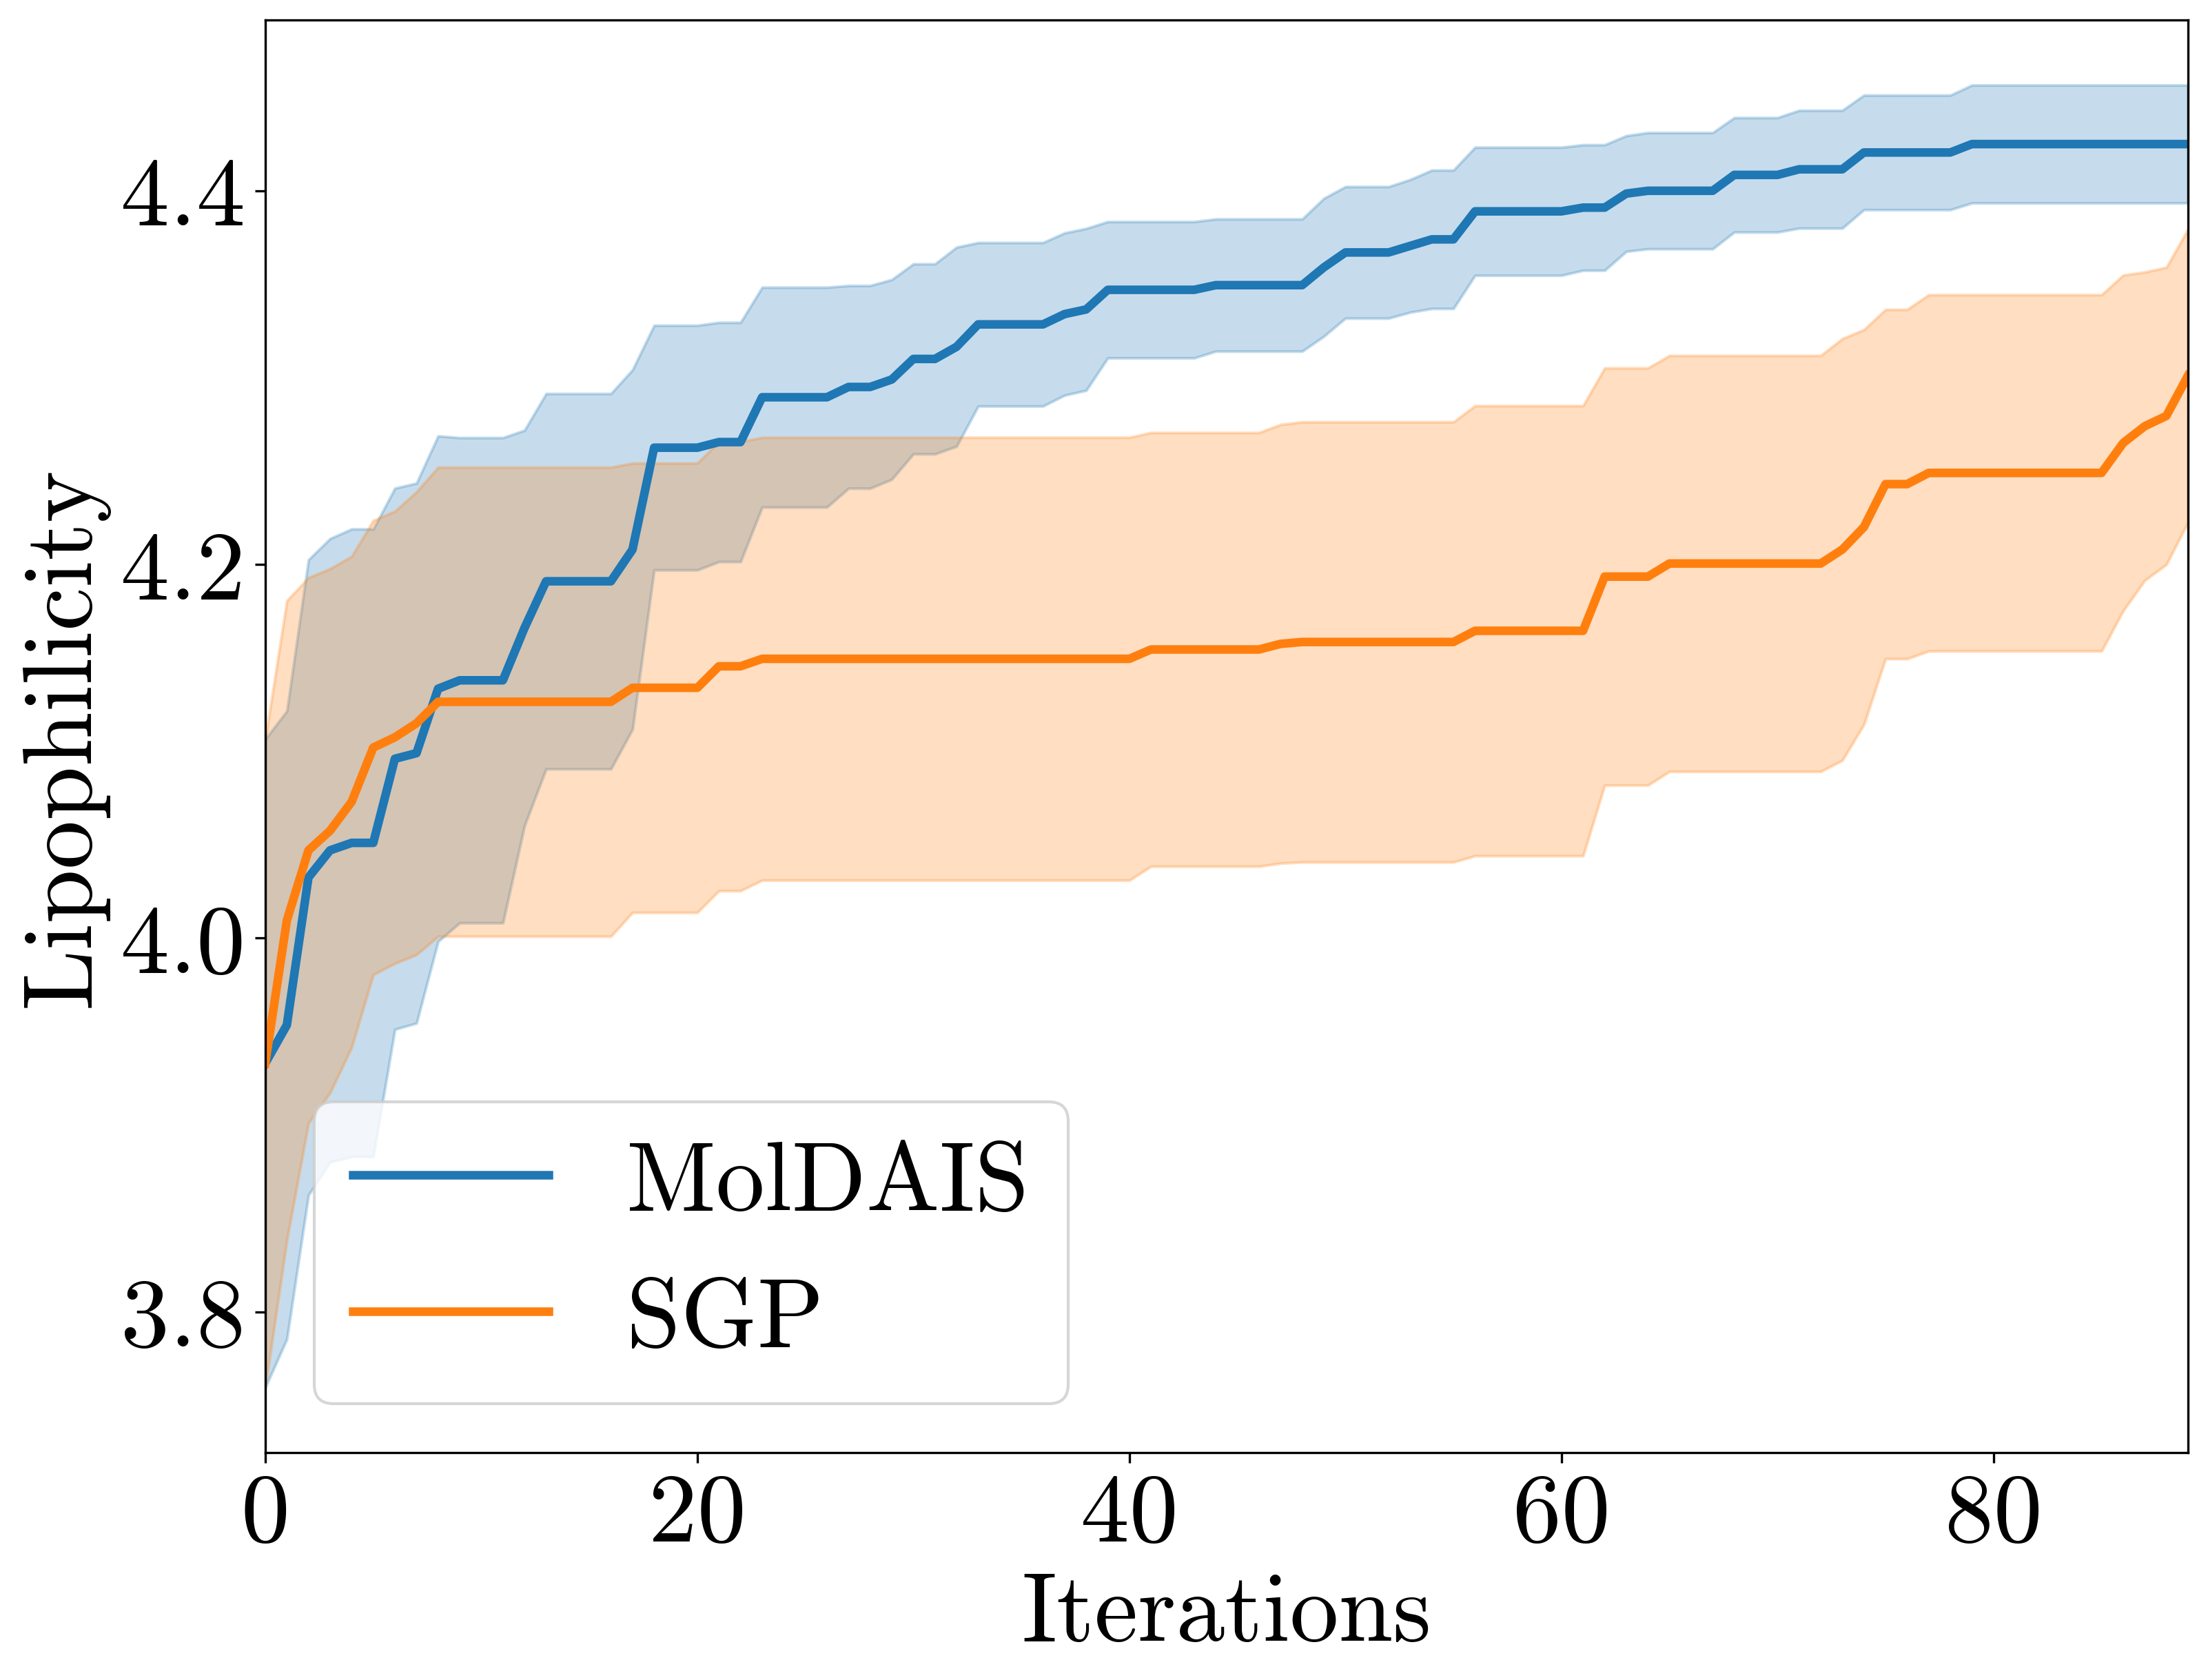

In [18]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#01015c','#0302FC', ] 


names = ['SAAS','GP_full', ]
names2 = ['MolDAIS','SGP',]

fig = plt.figure(figsize=(12,9))
for i, method in enumerate(names):
    style = '-'
    conv_results = Res_dict_stat[method]
    plt.plot(sample_numbers[:end], conv_results[0,:end,0], style, linewidth=3, label=names2[i], c=colors[i])
    plt.fill_between(sample_numbers[:end], conv_results[0,:end,0]-(1.95*conv_results[0,:end,1]/(len(seeds)**0.5)), conv_results[0,:end,0]+(1.95*conv_results[0,:end,1]/(len(seeds)**0.5)), alpha=0.25, color=colors[i])
plt.legend(loc=0)
#plt.title('Convergence Results Across ' + str(len(seeds)) + ' Runs with ' + str(init_budget) + ' Initial Random Samples')
plt.xlabel('Iterations')
plt.ylabel('Lipophilicity' )
#plt.yscale('log')
plt.xlim(0,90+end)    
#plt.ylim(0.04,1)#.75)    
plt.savefig('./figs/lipo/Convergence2.png')
    
    
'''
fig = plt.figure(figsize=(12,9))
for i, method in enumerate(names):
    style = '-'
    conv_results = Res_dict_stat[method]
    plt.plot(sample_numbers[:end], conv_results[0,:end,0], style, linewidth=3, label=names2[i], c=colors[i])
    plt.fill_between(sample_numbers[:end], conv_results[0,:end,0]-(1.95*conv_results[0,:end,1]/(len(seeds)**0.5)), conv_results[0,:end,0]+(1.95*conv_results[0,:end,1]/(len(seeds)**0.5)), alpha=0.25, color=colors[i])
plt.legend(loc=0)
#plt.title('Convergence Results Across ' + str(len(seeds)) + ' Runs with ' + str(init_budget) + ' Initial Random Samples')
plt.xlabel('Iterations')
plt.ylabel('Regret' )
plt.yscale('log')
plt.xlim(0,90+end)    
#plt.ylim(0.04,1)#.75) 
plt.savefig('./figs/lipo/Convergence_log.png')
'''
        
'''    
#sorted_results
fig = plt.figure(figsize=(12,9))
for i, method in enumerate(names):
    
    style = '-'
    sorted_results = Res_dict_raw[method]
    plt.plot(sample_numbers, -1*sorted_results.squeeze(0).T+best, style, linewidth=3, label=method, c=colors[i])
    #plt.fill_between(sample_numbers, conv_results[i,:,0]-(1.95*conv_results[i,:,1]/(len(seeds)**0.5)), conv_results[i,:,0]+(1.95*conv_results[i,:,1]/(len(seeds)**0.5)), alpha=0.1, color=colors[i])
    #plt.title('Convergence Results Across ' + str(len(seeds)) + ' Runs with ' + str(init_budget) + ' Initial Random Samples')
plt.xlabel('Iterations')
plt.ylabel('Regret' )
#plt.yscale('log')
plt.ylim(0,1)    
plt.xlim(0,90+end)   ''' 


In [182]:
mean_found-worst_found,best_found-mean_found

(0.17499997615814245,
 array([ 0.06499979,  0.05500004, -0.08499982,  0.05500004,  0.07500002,
        -0.04499986, -0.11500003,  0.05500004, -0.07500007, -0.0049999 ,
         0.06499979, -0.17499998,  0.00499985,  0.07500002,  0.06499979,
        -0.02499988, -0.07500007, -0.02499988,  0.05500004,  0.05500004]))

In [183]:
Res_dict_raw['SAAS'][0,:,-31]

array([4.4000001 , 4.48000002, 4.34000015, 4.48000002, 4.26000023,
       4.38000011, 4.30999994, 4.48000002, 4.30999994, 4.42000008,
       4.30999994, 4.25      , 4.42999983, 4.5       , 4.48999977,
       4.4000001 , 4.3499999 , 4.4000001 , 4.30999994, 4.48000002])

/tmp/ipykernel_4120285/3486970600.py:40: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,53,54,55,56,57,58,59,60,61,140,141,149,150,152,153,154,155,156,157,158,159,167,168,176,177,185,186,194,195,203,204,212,213,221,222,230,231,233,234,235,236,237,238,239,240,241,260,261,262,263,264,265,266,267,268,341,342,343,344,345,346,347,348,356,357,365,366,368,369,370,371,372,373,374,375,383,384,392,393,401,402,410,411,419,420,428,429,437,438,446,447,449,450,451,452,453,454,455,462,463,470,471,473,474,475,476,477,478,479,486,487,494,495,502,503,510,511,518,519,526,527,534,535,542,543,545,546,547,548,549,550,551,558,559,566,567,569,570,571,572,573,574,575,582,583,590,591,598,599,606,607,614,615,622,623,630,631,638,639,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711

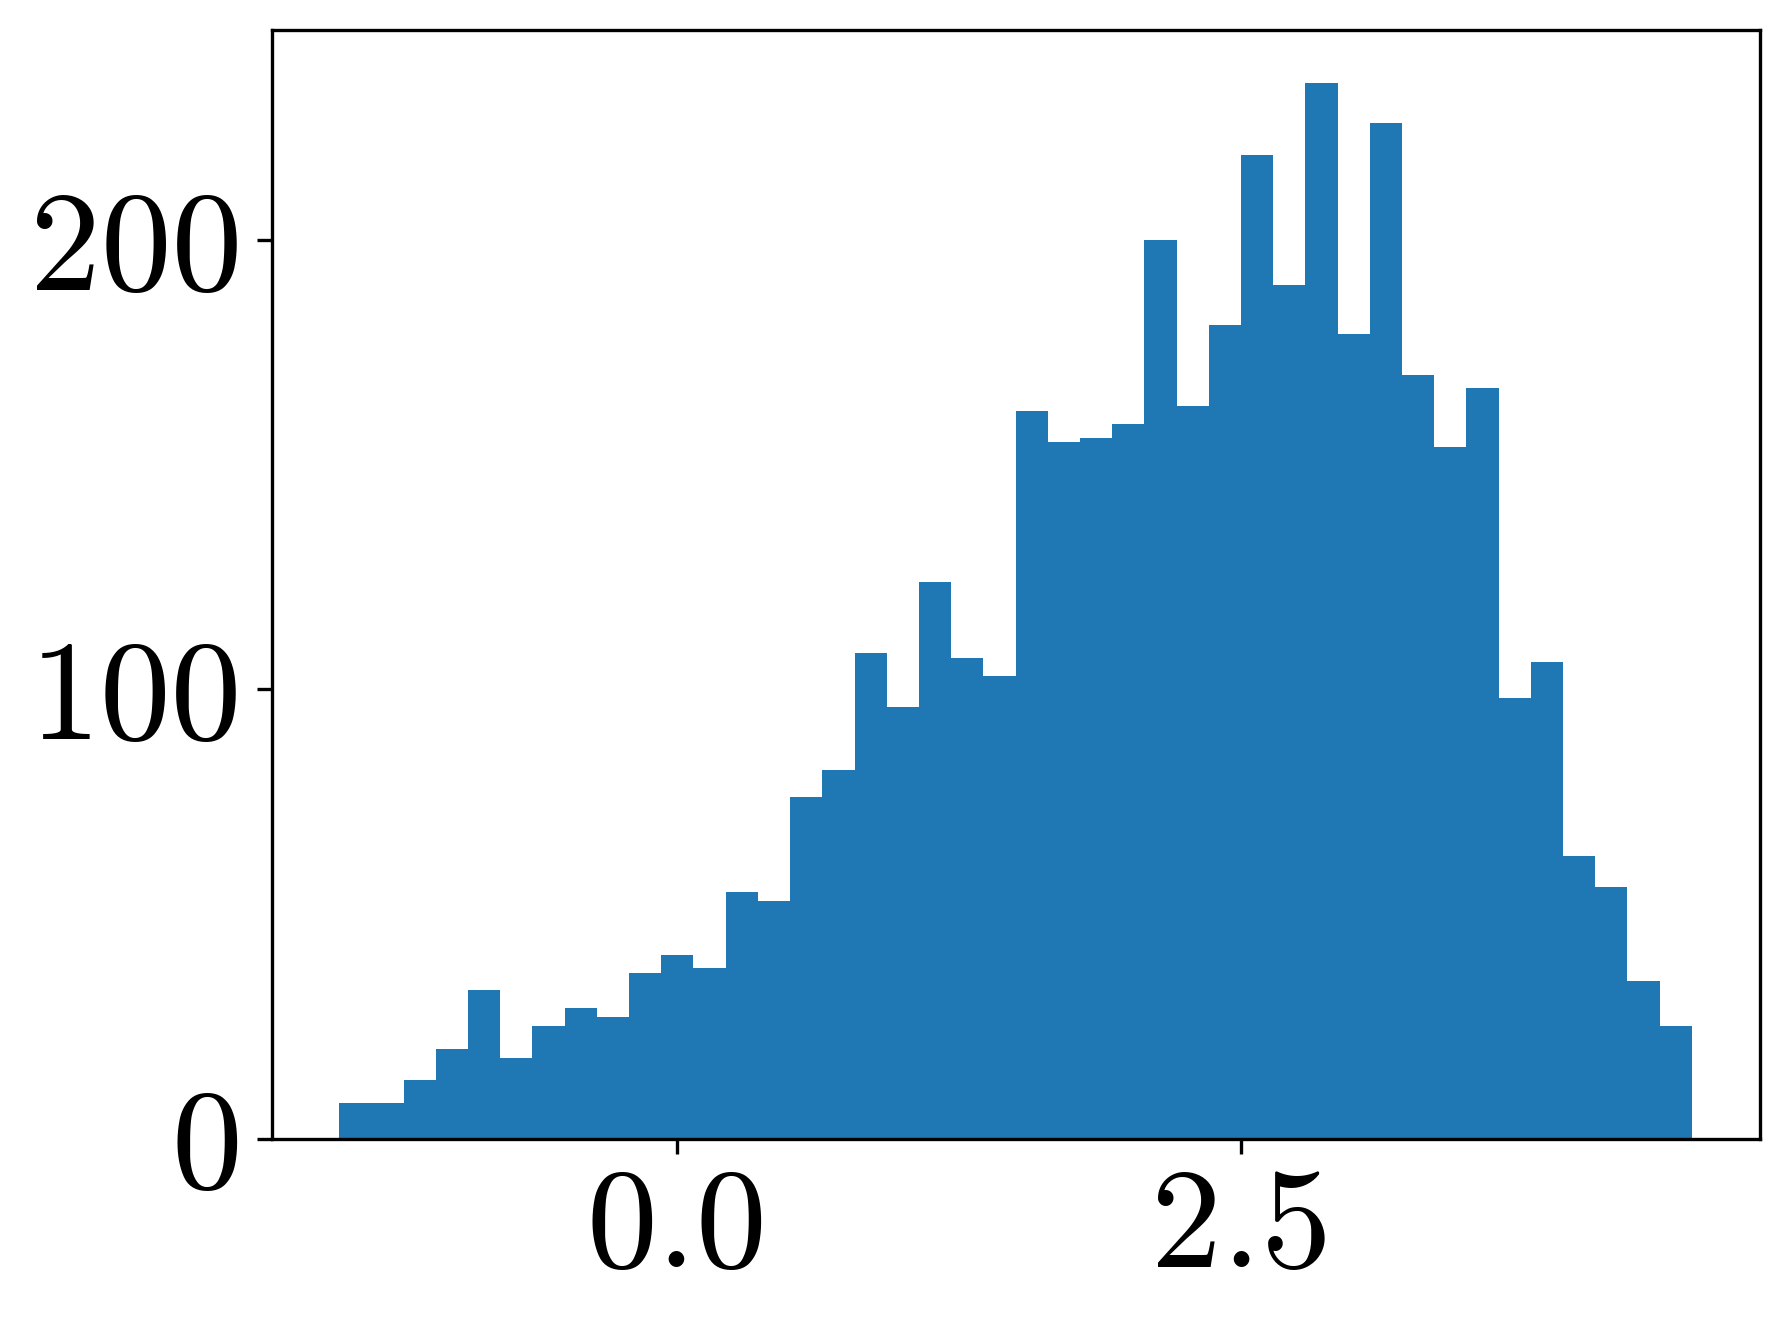

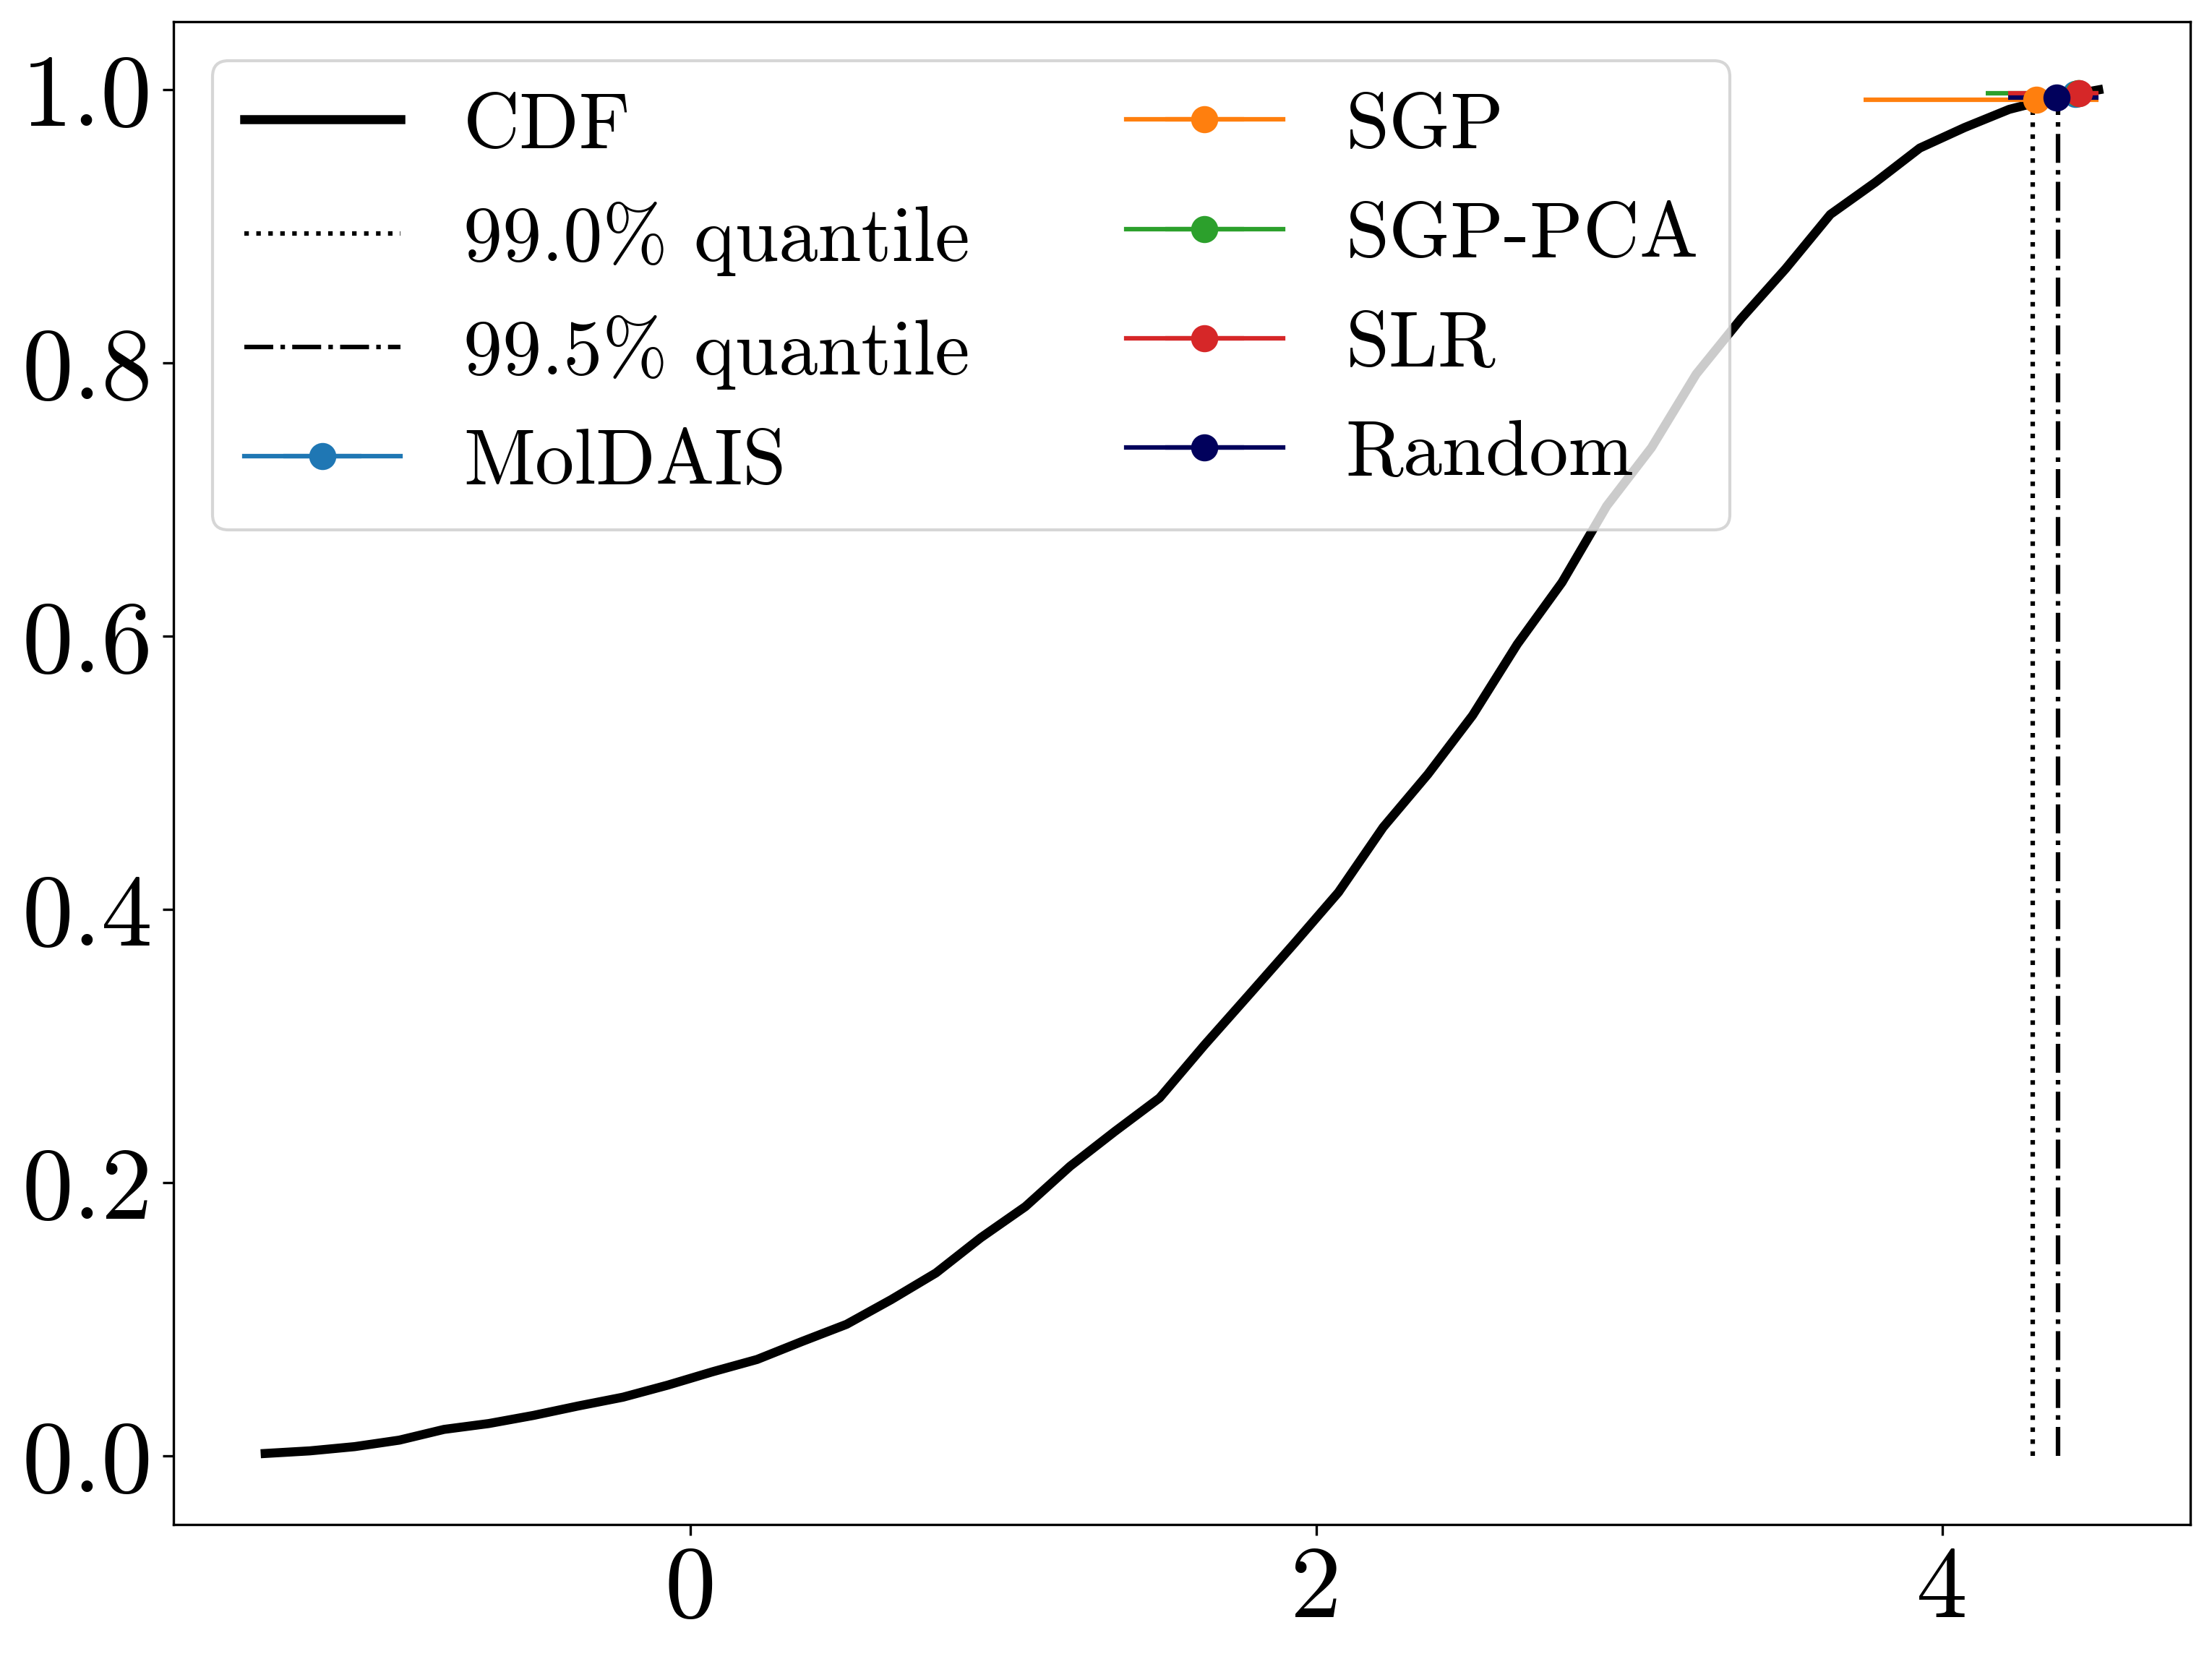

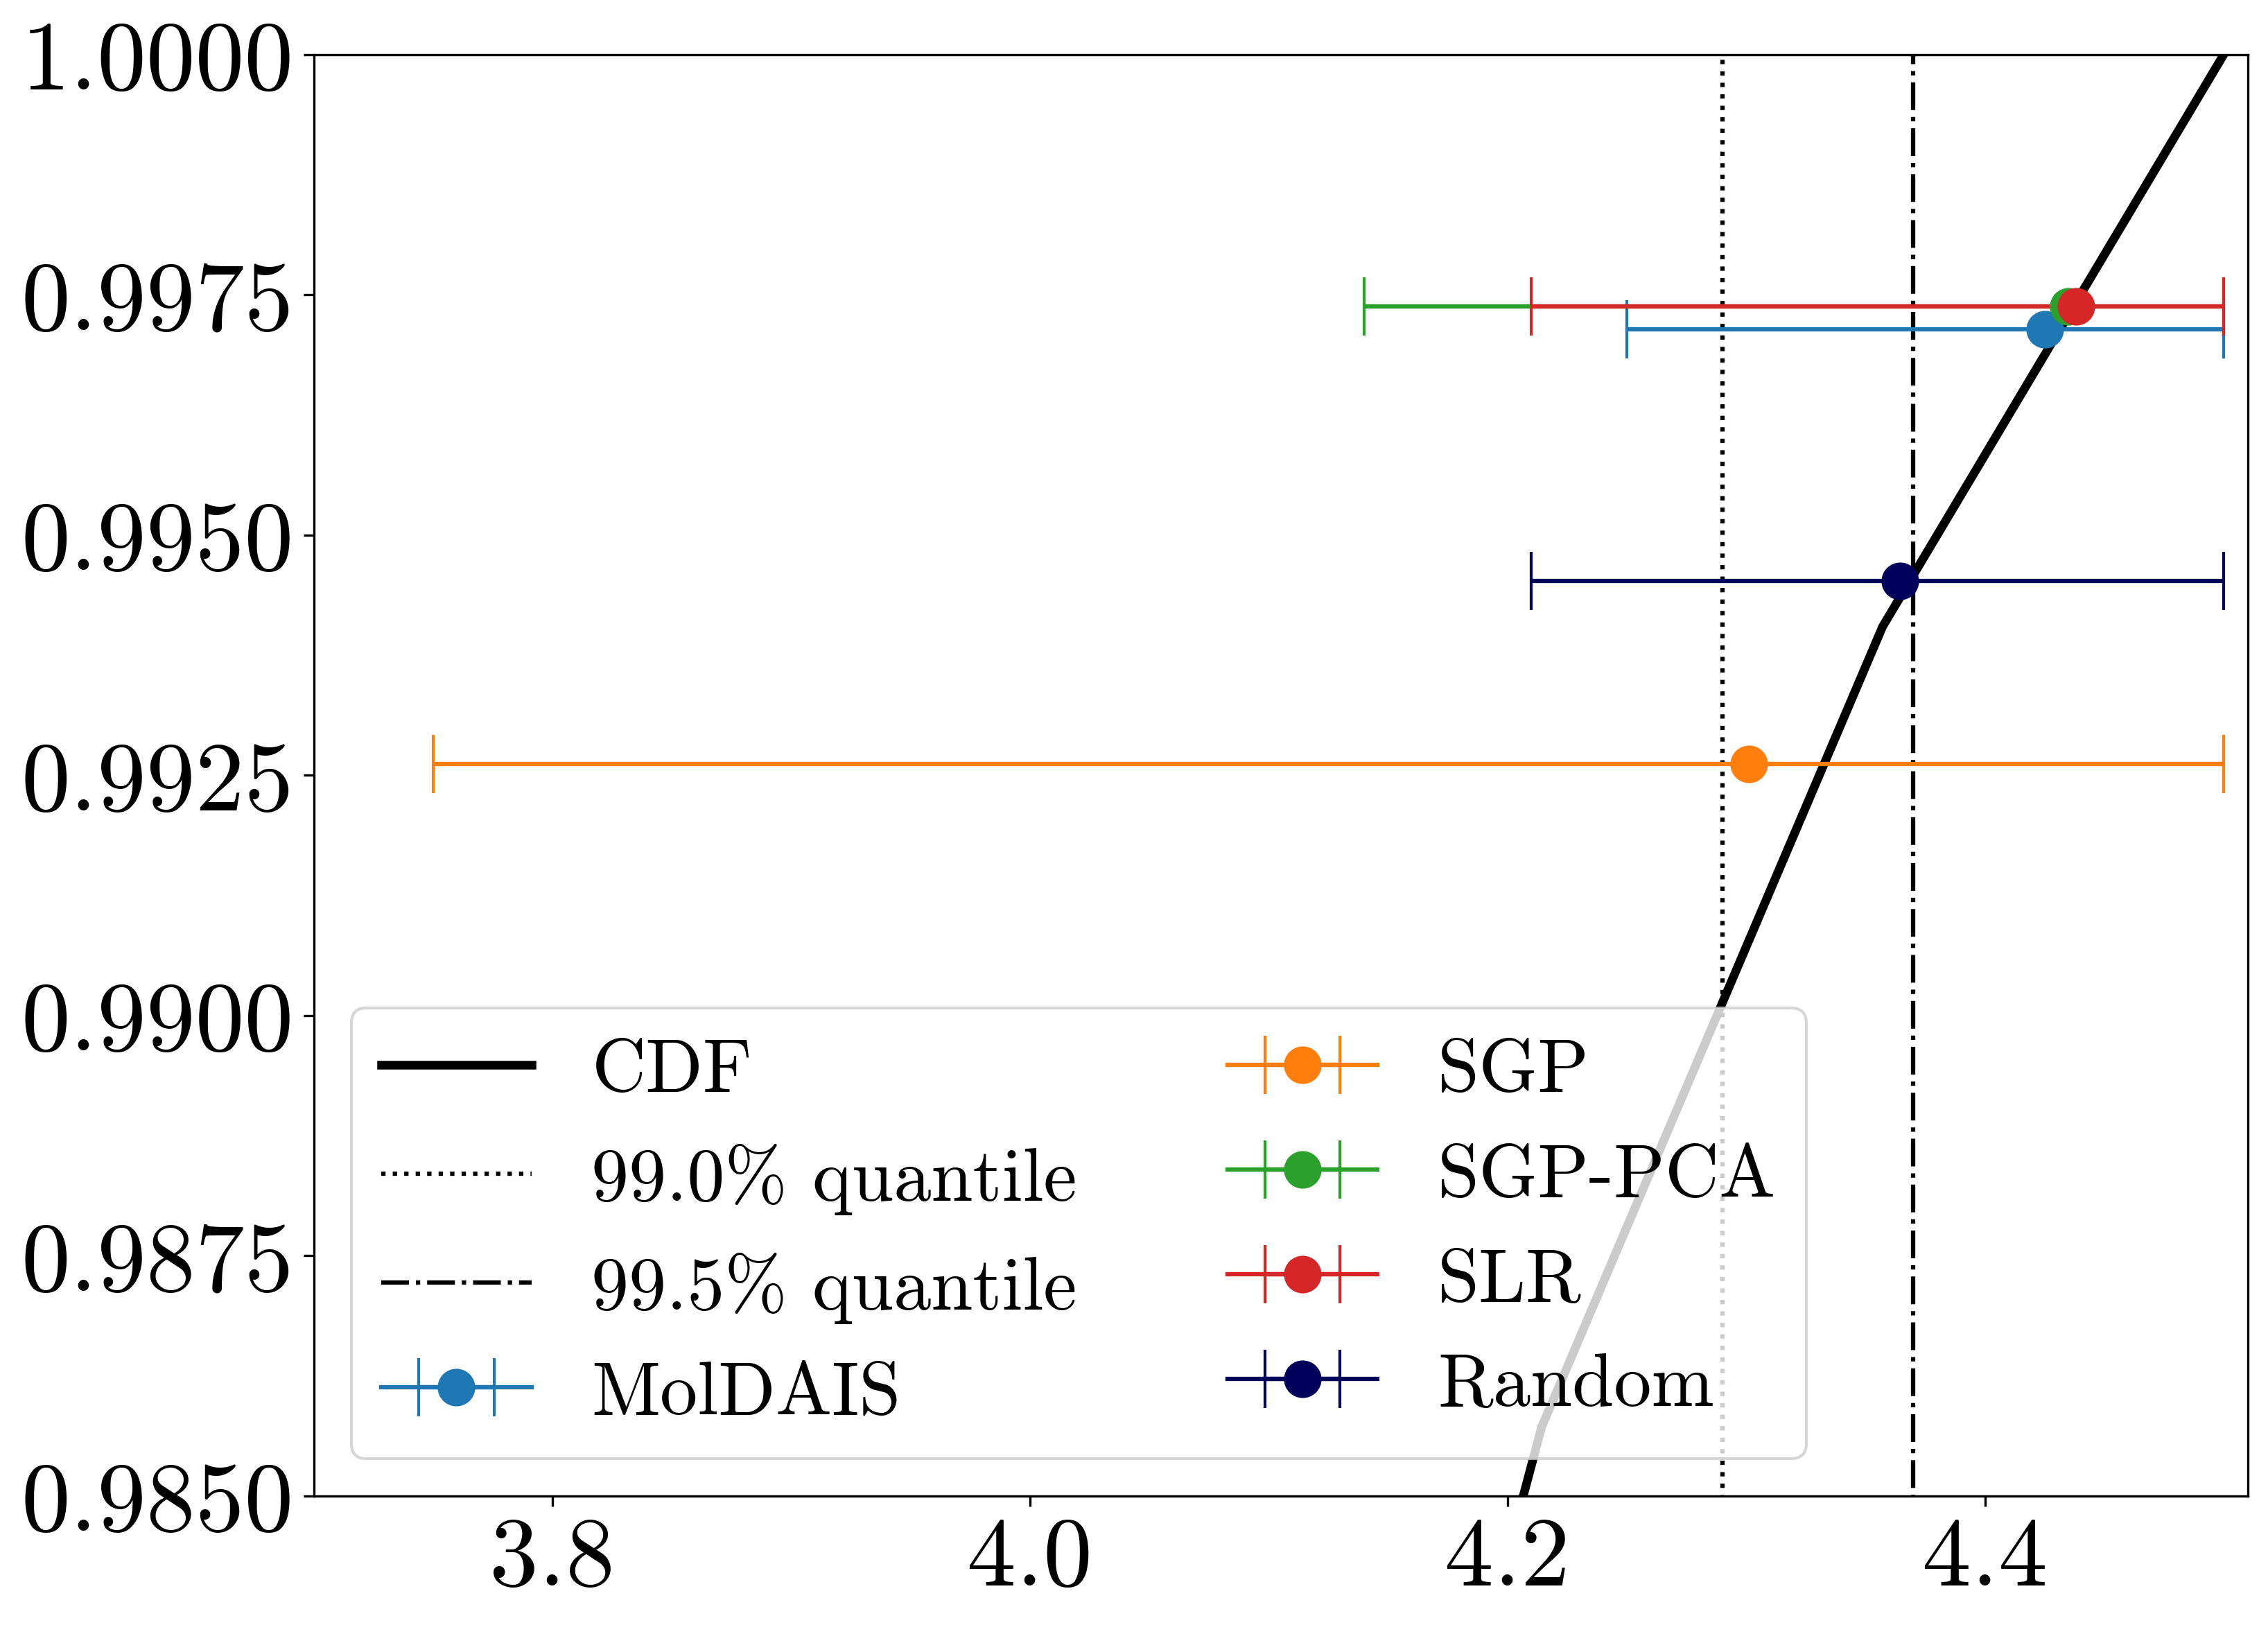

In [260]:
from scipy.stats import percentileofscore

end=-2
sorted_results = Res_dict_raw['SAAS']
Res_dict_stat['SAAS']
best_found = (sorted_results[0,:,end].max() )#- dmax)*-1 
worst_found = (sorted_results[0,:,end].min())# - dmax)*-1 
mean_found = (sorted_results[0,:,end].mean() )#- dmax)*-1 

sorted_results = Res_dict_raw['GP_full']
Res_dict_stat['GP_full']
best_found2 = (sorted_results[0,:,end].max() )#- dmax)*-1 
worst_found2 = (sorted_results[0,:,end].min() )#- dmax)*-1 
mean_found2 = (sorted_results[0,:,end].mean() )#- dmax)*-1 


sorted_results = Res_dict_raw['GP_PCA']
Res_dict_stat['GP_PCA']
best_found3 = (sorted_results[0,:,end].max() )#- dmax)*-1 
worst_found3 = (sorted_results[0,:,end].min() )#- dmax)*-1 
mean_found3 = (sorted_results[0,:,end].mean() )#- dmax)*-1 


sorted_results = Res_dict_raw['Linear']
Res_dict_stat['Linear']
best_found4 = (sorted_results[0,:,end].max() )#- dmax)*-1 
worst_found4 = (sorted_results[0,:,end].min() )#- dmax)*-1 
mean_found4 = (sorted_results[0,:,end].mean() )#- dmax)*-1 


sorted_results = Res_dict_raw['random']
Res_dict_stat['random']
best_found5 = (sorted_results[0,:,end].max() )#- dmax)*-1 
worst_found5 = (sorted_results[0,:,end].min() )#- dmax)*-1 
mean_found5 = (sorted_results[0,:,end].mean() )#- dmax)*-1 




df = pd.read_csv('../prop_data/MORDRED_SMILES_lipophilicity_exp.csv')
dmin, dmax = df['activity'].min(), df['activity'].max()


ms = 8
cs = 8

import matplotlib.patches as patches
inp = torch.tensor(df['activity'].to_numpy())
quantile = .99

act_quant = percentileofscore(df['activity'].to_list(),mean_found)/100
act_quant2 = percentileofscore(df['activity'].to_list(),mean_found2)/100
act_quant3 = percentileofscore(df['activity'].to_list(),mean_found3)/100
act_quant4 = percentileofscore(df['activity'].to_list(),mean_found4)/100
act_quant5 = percentileofscore(df['activity'].to_list(),mean_found5)/100

hist = plt.hist(df['activity'],bins=int(len(df['activity'])/100))

fig, ax = plt.subplots(figsize=(12,9))
count, bins_count = hist[0], hist[1]
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF", linewidth=3, color='k')
plt.vlines(torch.quantile(inp,quantile) , 0,1, color='k', linestyle=':', label= f'{quantile*100:.1f}% quantile')
plt.vlines(torch.quantile(inp,.995) , 0,1, color='k', linestyle='-.', label= f'{.995*100:.1f}% quantile')
plt.errorbar([mean_found], [act_quant],   xerr=np.array([[np.abs(mean_found-worst_found),np.abs(best_found-mean_found)]]).reshape(2,1),      color=colors[0], marker='o', label= names2[0], markersize=ms)
plt.errorbar([mean_found2], [act_quant2], xerr=np.array([[np.abs(mean_found2-worst_found2),np.abs(best_found2-mean_found2)]]).reshape(2,1),  color=colors[1], marker='o', label= names2[1], markersize=ms)
plt.errorbar([mean_found3], [act_quant3], xerr=np.array([[np.abs(mean_found3-worst_found3),np.abs(best_found3-mean_found3)]]).reshape(2,1),  color=colors[2], marker='o', label= names2[2], markersize=ms)
plt.errorbar([mean_found4], [act_quant4], xerr=np.array([[np.abs(mean_found4-worst_found4),np.abs(best_found4-mean_found4)]]).reshape(2,1),  color=colors[3], marker='o', label= names2[3], markersize=ms)
plt.errorbar([mean_found5], [act_quant5], xerr=np.array([[np.abs(mean_found5-worst_found5),np.abs(best_found5-mean_found5)]]).reshape(2,1),  color=colors[4], marker='o', label= names2[4], markersize=ms)
plt.legend(ncols=2, fontsize=26, loc = 2)
plt.savefig('./figs/lipo/CDF_quantiles.png')



ms = 12
cs = 12

fig, ax = plt.subplots(figsize=(12,9))
count, bins_count = hist[0], hist[1]
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF", linewidth=3, color='k')
plt.vlines(torch.quantile(inp,quantile) , 0,1, color='k', linestyle=':', label= f'{quantile*100:.1f}% quantile')
plt.vlines(torch.quantile(inp,.995) , 0,1, color='k', linestyle='-.', label= f'{.995*100:.1f}% quantile')
plt.errorbar([mean_found], [act_quant],   xerr=np.array([[np.abs(mean_found-worst_found),np.abs(best_found-mean_found)]]).reshape(2,1),      color=colors[0], marker='o', label= names2[0], markersize=ms,capsize=10)
plt.errorbar([mean_found2], [act_quant2], xerr=np.array([[np.abs(mean_found2-worst_found2),np.abs(best_found2-mean_found2)]]).reshape(2,1),  color=colors[1], marker='o', label= names2[1], markersize=ms,capsize=10)
plt.errorbar([mean_found3], [act_quant3], xerr=np.array([[np.abs(mean_found3-worst_found3),np.abs(best_found3-mean_found3)]]).reshape(2,1),  color=colors[2], marker='o', label= names2[2], markersize=ms,capsize=10)
plt.errorbar([mean_found4], [act_quant4], xerr=np.array([[np.abs(mean_found4-worst_found4),np.abs(best_found4-mean_found4)]]).reshape(2,1),  color=colors[3], marker='o', label= names2[3], markersize=ms,capsize=10)
plt.errorbar([mean_found5], [act_quant5], xerr=np.array([[np.abs(mean_found5-worst_found5),np.abs(best_found5-mean_found5)]]).reshape(2,1),  color=colors[4], marker='o', label= names2[4], markersize=ms,capsize=10)
plt.legend(loc='lower left',ncols=2, fontsize=26)
#plt.xscale("log")
plt.xlim(dmax-0.8, dmax+.01)
plt.ylim(.985,1.0)
plt.savefig('./figs/lipo/CDF_quantiles_zoom.png')


/tmp/ipykernel_4120285/1699446177.py:24: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  hist = plt.hist(df['activity'],bins=int(len(df['activity'])/10))
/tmp/ipykernel_4120285/1699446177.py:28: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,9))
/tmp/ipykernel_4120285/1699446177.py:37: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,9))
/tmp/ipykernel_4120285/1699446177.py:50: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,9))


(4.0, 4.51)

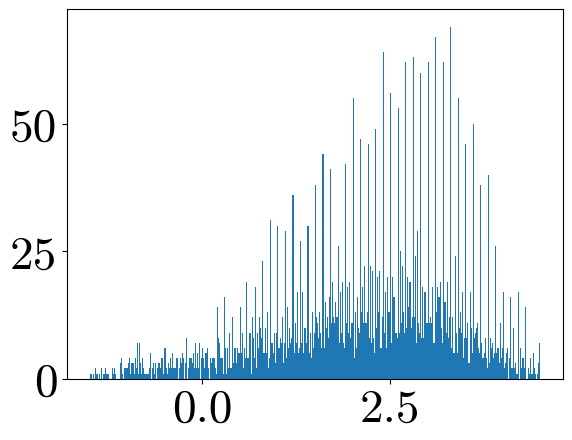

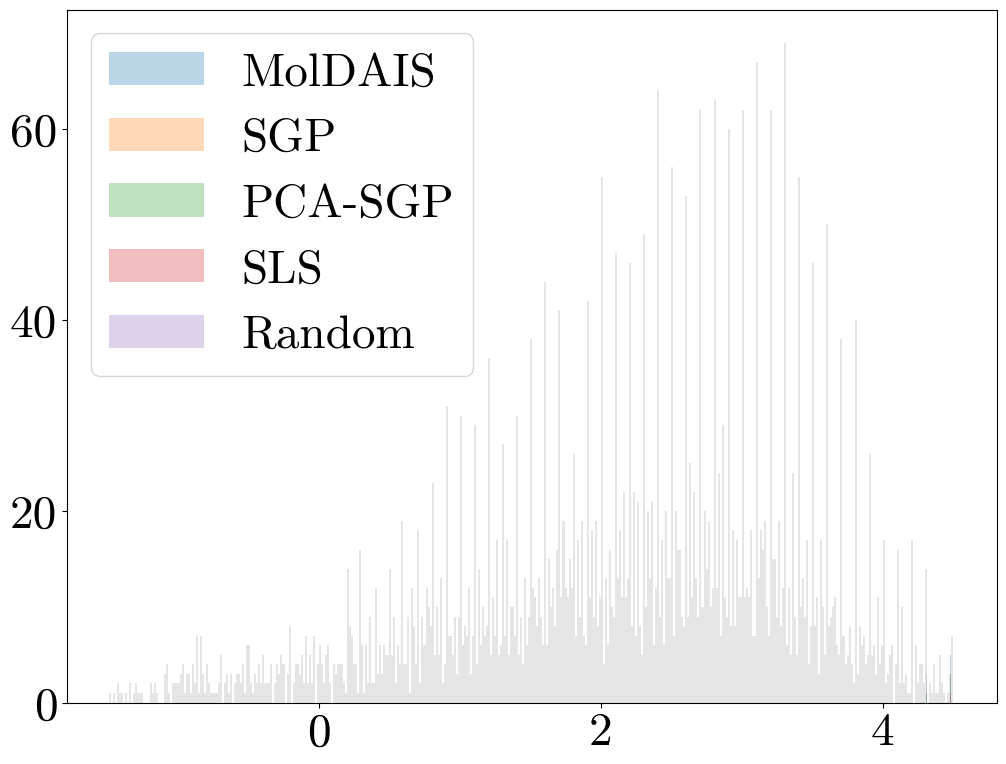

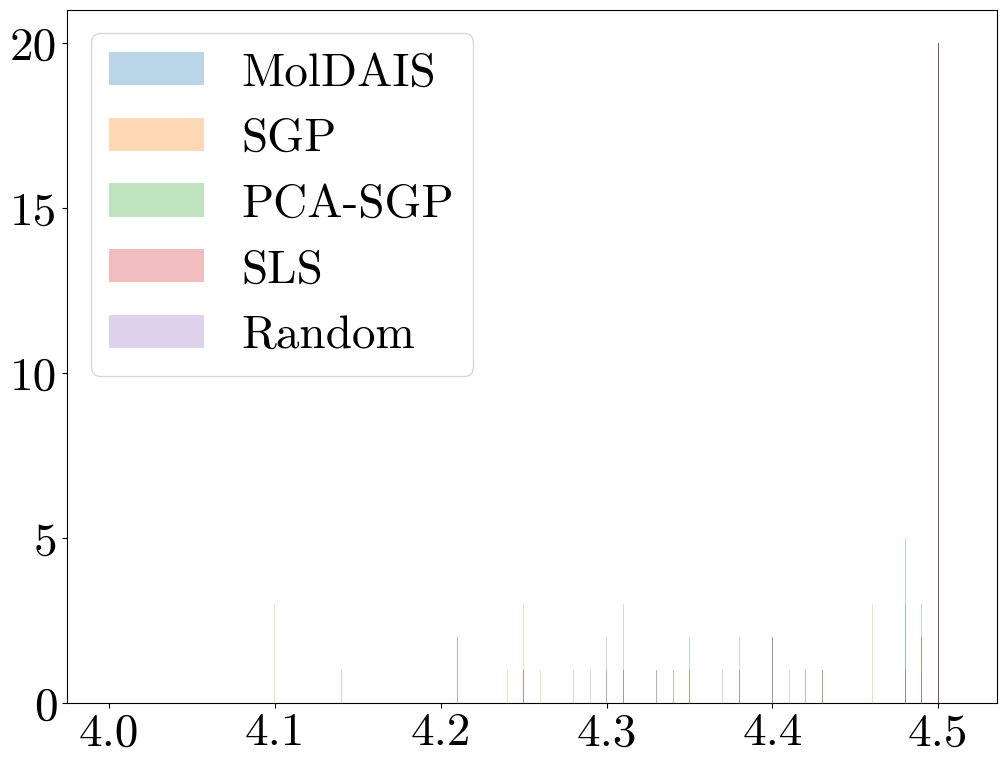

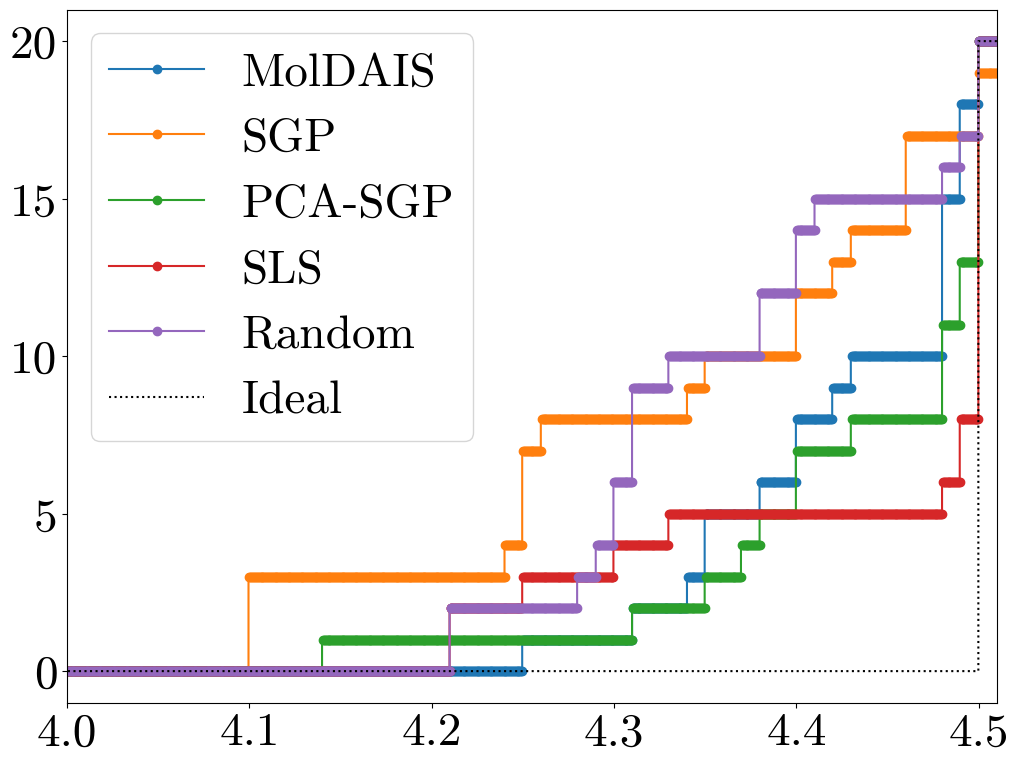

In [229]:


sorted_results = Res_dict_raw['SAAS']
Res_dict_stat['SAAS']
best_found = sorted_results[0,:,end]

sorted_results = Res_dict_raw['GP_full']
Res_dict_stat['GP_full']
best_found2 = sorted_results[0,:,end]

sorted_results = Res_dict_raw['GP_PCA']
Res_dict_stat['GP_PCA']
best_found3 = sorted_results[0,:,end]

sorted_results = Res_dict_raw['Linear']
Res_dict_stat['Linear']
best_found4 = sorted_results[0,:,end]

sorted_results = Res_dict_raw['random']
Res_dict_stat['random']
best_found5 = sorted_results[0,:,end]



count, bins_count = hist[0], hist[1]
hist = plt.hist(df['activity'],bins=int(len(df['activity'])/10))

bins = np.linspace(4,dmax+.01,1000)

fig, ax = plt.subplots(figsize=(12,9))
plt.hist(best_found,bins=bins, alpha=.3,label='MolDAIS')
plt.hist(best_found2,bins=bins,alpha=.3,label='SGP')
plt.hist(best_found3,bins=bins,alpha=.3,label='PCA-SGP')
plt.hist(best_found4,bins=bins,alpha=.3,label='SLS')
plt.hist(best_found5,bins=bins,alpha=.3,label='Random')
plt.hist(df['activity'],bins=bins_count[1:],alpha=.2, color='gray')
plt.legend()

fig, ax = plt.subplots(figsize=(12,9))
hist1 = plt.hist(best_found,bins=bins, alpha=.3,label='MolDAIS')
hist2 = plt.hist(best_found2,bins=bins,alpha=.3,label='SGP')
hist3 = plt.hist(best_found3,bins=bins,alpha=.3,label='PCA-SGP')
hist4 = plt.hist(best_found4,bins=bins,alpha=.3,label='SLS')
hist5 = plt.hist(best_found5,bins=bins,alpha=.3,label='Random')
#plt.hist(df['activity'],bins=bins_count[1:],alpha=.2, color='gray')
plt.legend()
#plt.xlim(0,3)
#plt.ylim(0,len(seeds)+1)

hist6 = plt.hist(best_found5*0+dmax, bins = bins)

fig, ax = plt.subplots(figsize=(12,9))
plt.step(hist1[1][1:],np.cumsum(hist1[0]),marker='o', alpha=1,label='MolDAIS')
plt.step(hist2[1][1:],np.cumsum(hist2[0]),marker='o', alpha=1,label='SGP')
plt.step(hist3[1][1:],np.cumsum(hist3[0]),marker='o', alpha=1,label='PCA-SGP')
plt.step(hist4[1][1:],np.cumsum(hist4[0]),marker='o', alpha=1,label='SLS')
plt.step(hist5[1][1:],np.cumsum(hist5[0]),marker='o', alpha=1,label='Random')
plt.step(hist6[1][1:],np.cumsum(hist6[0]), 'k:', alpha=1,label='Ideal')
#plt.hist(df['activity'],bins=bins_count[1:],alpha=.2, color='gray')
plt.legend()
plt.xlim(4,dmax+0.01)
#plt.ylim(0,len(seeds)+1)




In [186]:
inp = torch.tensor(df['activity'].to_numpy())
torch.quantile(inp,.995),torch.quantile(inp,.997),torch.quantile(inp,.999) 

(tensor(4.3701, dtype=torch.float64),
 tensor(4.4200, dtype=torch.float64),
 tensor(4.4900, dtype=torch.float64))

In [222]:
np.cumsum(hist6[0])

array([ 0.,  0.,  0.,  0.,  0., 20., 20., 20., 20., 20.])

In [188]:
worst_found,mean_found , best_found

(4.25,
 4.4249999761581424,
 array([4.48999977, 4.48000002, 4.34000015, 4.48000002, 4.5       ,
        4.38000011, 4.30999994, 4.48000002, 4.3499999 , 4.42000008,
        4.48999977, 4.25      , 4.42999983, 4.5       , 4.48999977,
        4.4000001 , 4.3499999 , 4.4000001 , 4.48000002, 4.48000002]))

In [189]:
# plot molecule sample sequence
import rdkit as rd
from rdkit.Chem import Draw

bestsmis = df['SMILES'][df['activity']>=4.5].to_list()


sorted_results1 = Res_dict_raw['SAAS']
sorted_results2 = Res_dict_raw['GP_full']
sorted_results3 = Res_dict_raw['GP_PCA']
sorted_results4 = Res_dict_raw['Linear']

idx = 4




set1 = sorted_results1[0,idx,:]
set2 = sorted_results2[0,idx,:]
set3 = sorted_results3[0,idx,:]
set4 = sorted_results4[0,idx,:]

smis1 = Smi_dict_stat['SAAS'][idx]
smis2 = Smi_dict_stat['GP_full'][idx]
smis3 = Smi_dict_stat['GP_PCA'][idx]
smis4 = Smi_dict_stat['Linear'][idx]


smi1 = []
smi2 = []
smi3 = []
smi4 = []
m1, m2, m3, m4 = set1[0],  set2[0], set3[0], set4[0]

idx_list1 = []
idx_list2 = []
idx_list3 = []
idx_list4 = []

for i in sample_numbers[1:]:
    
    i1 = set1[:i].max()
    i2 = set2[:i].max()
    i3 = set3[:i].max()
    i4 = set4[:i].max()

    
    if i1>m1 or smis1[i] in bestsmis:
        smi1.append(rd.Chem.MolFromSmiles(smis1[i]))
        m1 = i1
        idx_list1.append([i, i1])
        
    if i2>m2 or smis2[i] in bestsmis:
        smi2.append(rd.Chem.MolFromSmiles(smis2[i]))
        m2 = i2
        idx_list2.append([i,i2])        
        
    if i3>m3 or smis3[i] in bestsmis:
        smi3.append(rd.Chem.MolFromSmiles(smis3[i]))
        m3 = i3
        idx_list3.append([i,i3])        
            
    if i4>m4 or smis4[i] in bestsmis:
        smi4.append(rd.Chem.MolFromSmiles(smis4[i]))
        m4 = i4
        idx_list4.append([i,i4])      


In [252]:
legend=['Itr: '+ str(x[0])+'  =  '+f" {x[1]:.3f}" for x in idx_list1]
print("MolDAIS")
img = rd.Chem.Draw.MolsToGridImage(smi1,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)

png = img.data
with open('./figs/malaria/mols_SAAS.png','wb+') as outf:
    outf.write(png)

MolDAIS


In [253]:
legend=['Itr: '+ str(x[0])+'  =  '+f" {x[1]:.3f}" for x in idx_list2]
print("SBO-PCA")
img = rd.Chem.Draw.MolsToGridImage(smi2,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)

png = img.data
with open('./figs/malaria/mols_SBOPCAt.png','wb+') as outf:
    outf.write(png)

SBO-PCA


In [254]:
legend=['Itr: '+ str(x[0])+'  =  '+f" {x[1]:.3f}" for x in idx_list4]
print('SLR')
img = rd.Chem.Draw.MolsToGridImage(smi4,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)

png = img.data
with open('./figs/malaria/mols_SLR.png','wb+') as outf:
    outf.write(png)

SLR


In [255]:
legend=['Itr: '+ str(x[0])+'  =  '+f" {x[1]:.3f}" for x in idx_list3]
print('SBO')
img = rd.Chem.Draw.MolsToGridImage(smi3,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)

png = img.data
with open('./figs/malaria/mols_SBO.png','wb+') as outf:
    outf.write(png)

SBO


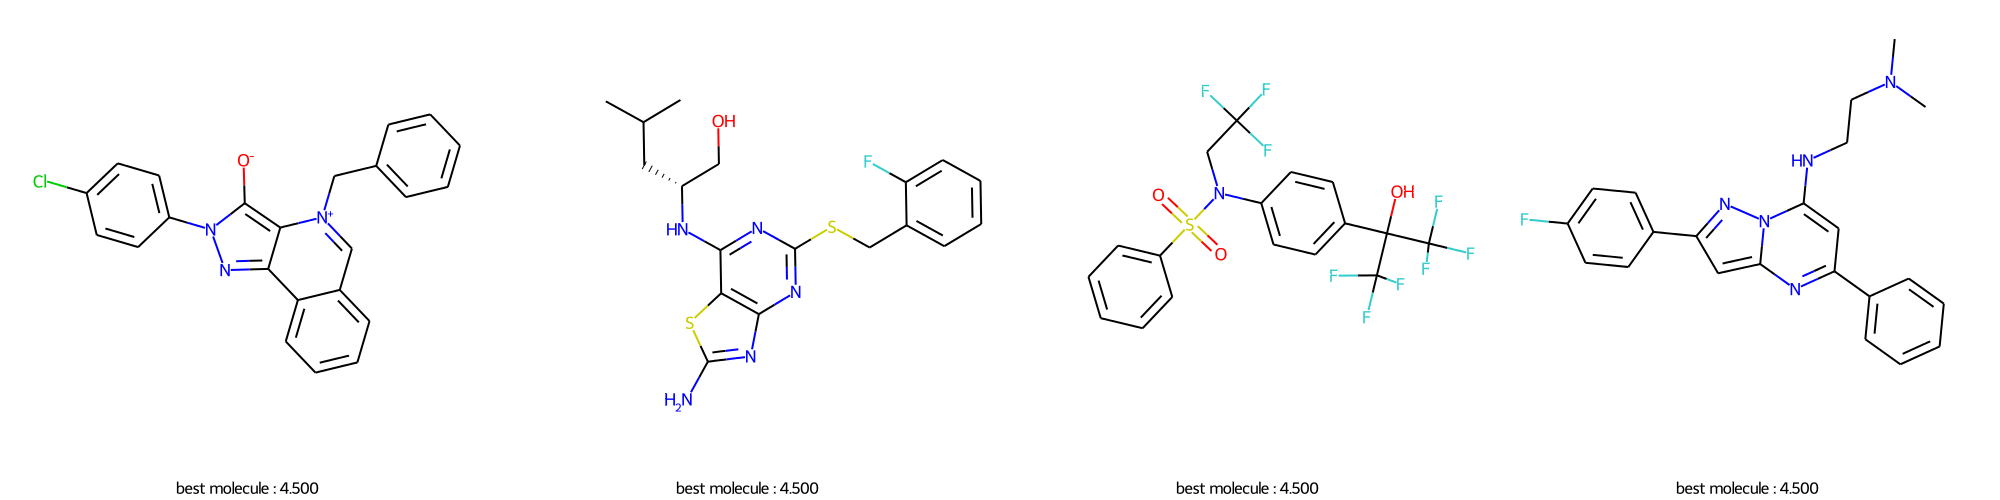

In [256]:
bestsmis = df['SMILES'][df['activity']>=best].to_list()
bestmol=[]
for i in bestsmis: 
    bestmol.append(rd.Chem.MolFromSmiles( i))
bestval =  df['activity'][df['activity']>=best].to_list()
legend = [f"best molecule : {bestval[i]:.3f}" for i in range(len(bestval))]

img = rd.Chem.Draw.MolsToGridImage(bestmol,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)



png = img.data
with open('./figs/malaria/mols_best.png','wb+') as outf:
    outf.write(png)
    
rd.Chem.Draw.MolsToGridImage(bestmol,molsPerRow=4,subImgSize=(500,500),useSVG=False,legends=legend)


In [195]:
legend

['best molecule : 4.500',
 'best molecule : 4.500',
 'best molecule : 4.500',
 'best molecule : 4.500']

In [196]:

rr1= []
for k,i in enumerate(smis1):
    if i in  df['SMILES'].to_list():
        rr1.append(df[df['SMILES']==i]['activity'].item())
        
rr2= []
for k,i in enumerate(smis2):
    if i in  df['SMILES'].to_list():
        rr2.append(df[df['SMILES']==i]['activity'].item())
        
rr4= []
for k,i in enumerate(smis4):
    if i in  df['SMILES'].to_list():
        rr4.append(df[df['SMILES']==i]['activity'].item())
        
rr3= []
for k,i in enumerate(smis3):
    if i in  df['SMILES'].to_list():
        rr3.append(df[df['SMILES']==i]['activity'].item())
        
        
print(np.array(rr1).max())
print(np.array(rr2).max())
print(np.array(rr4).max())
print(np.array(rr3).max())

4.5
4.25
4.5
4.31


In [197]:
np.array(df['activity'].to_list()).min()#[df['activity']>=11.]

-1.5

In [198]:
print(sorted_results1[0,:,-1])
print(sorted_results2[0,:,-1])
print(sorted_results3[0,:,-1])
print(sorted_results4[0,:,-1])
sorted_results1.shape

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


(1, 20, 91)

/tmp/ipykernel_4120285/1230321670.py:38: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.axvline(i, color=C[i], linestyle='-', zorder=0)
/tmp/ipykernel_4120285/1230321670.py:52: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.axvline(i, color=C[i], linestyle='-', zorder=0)


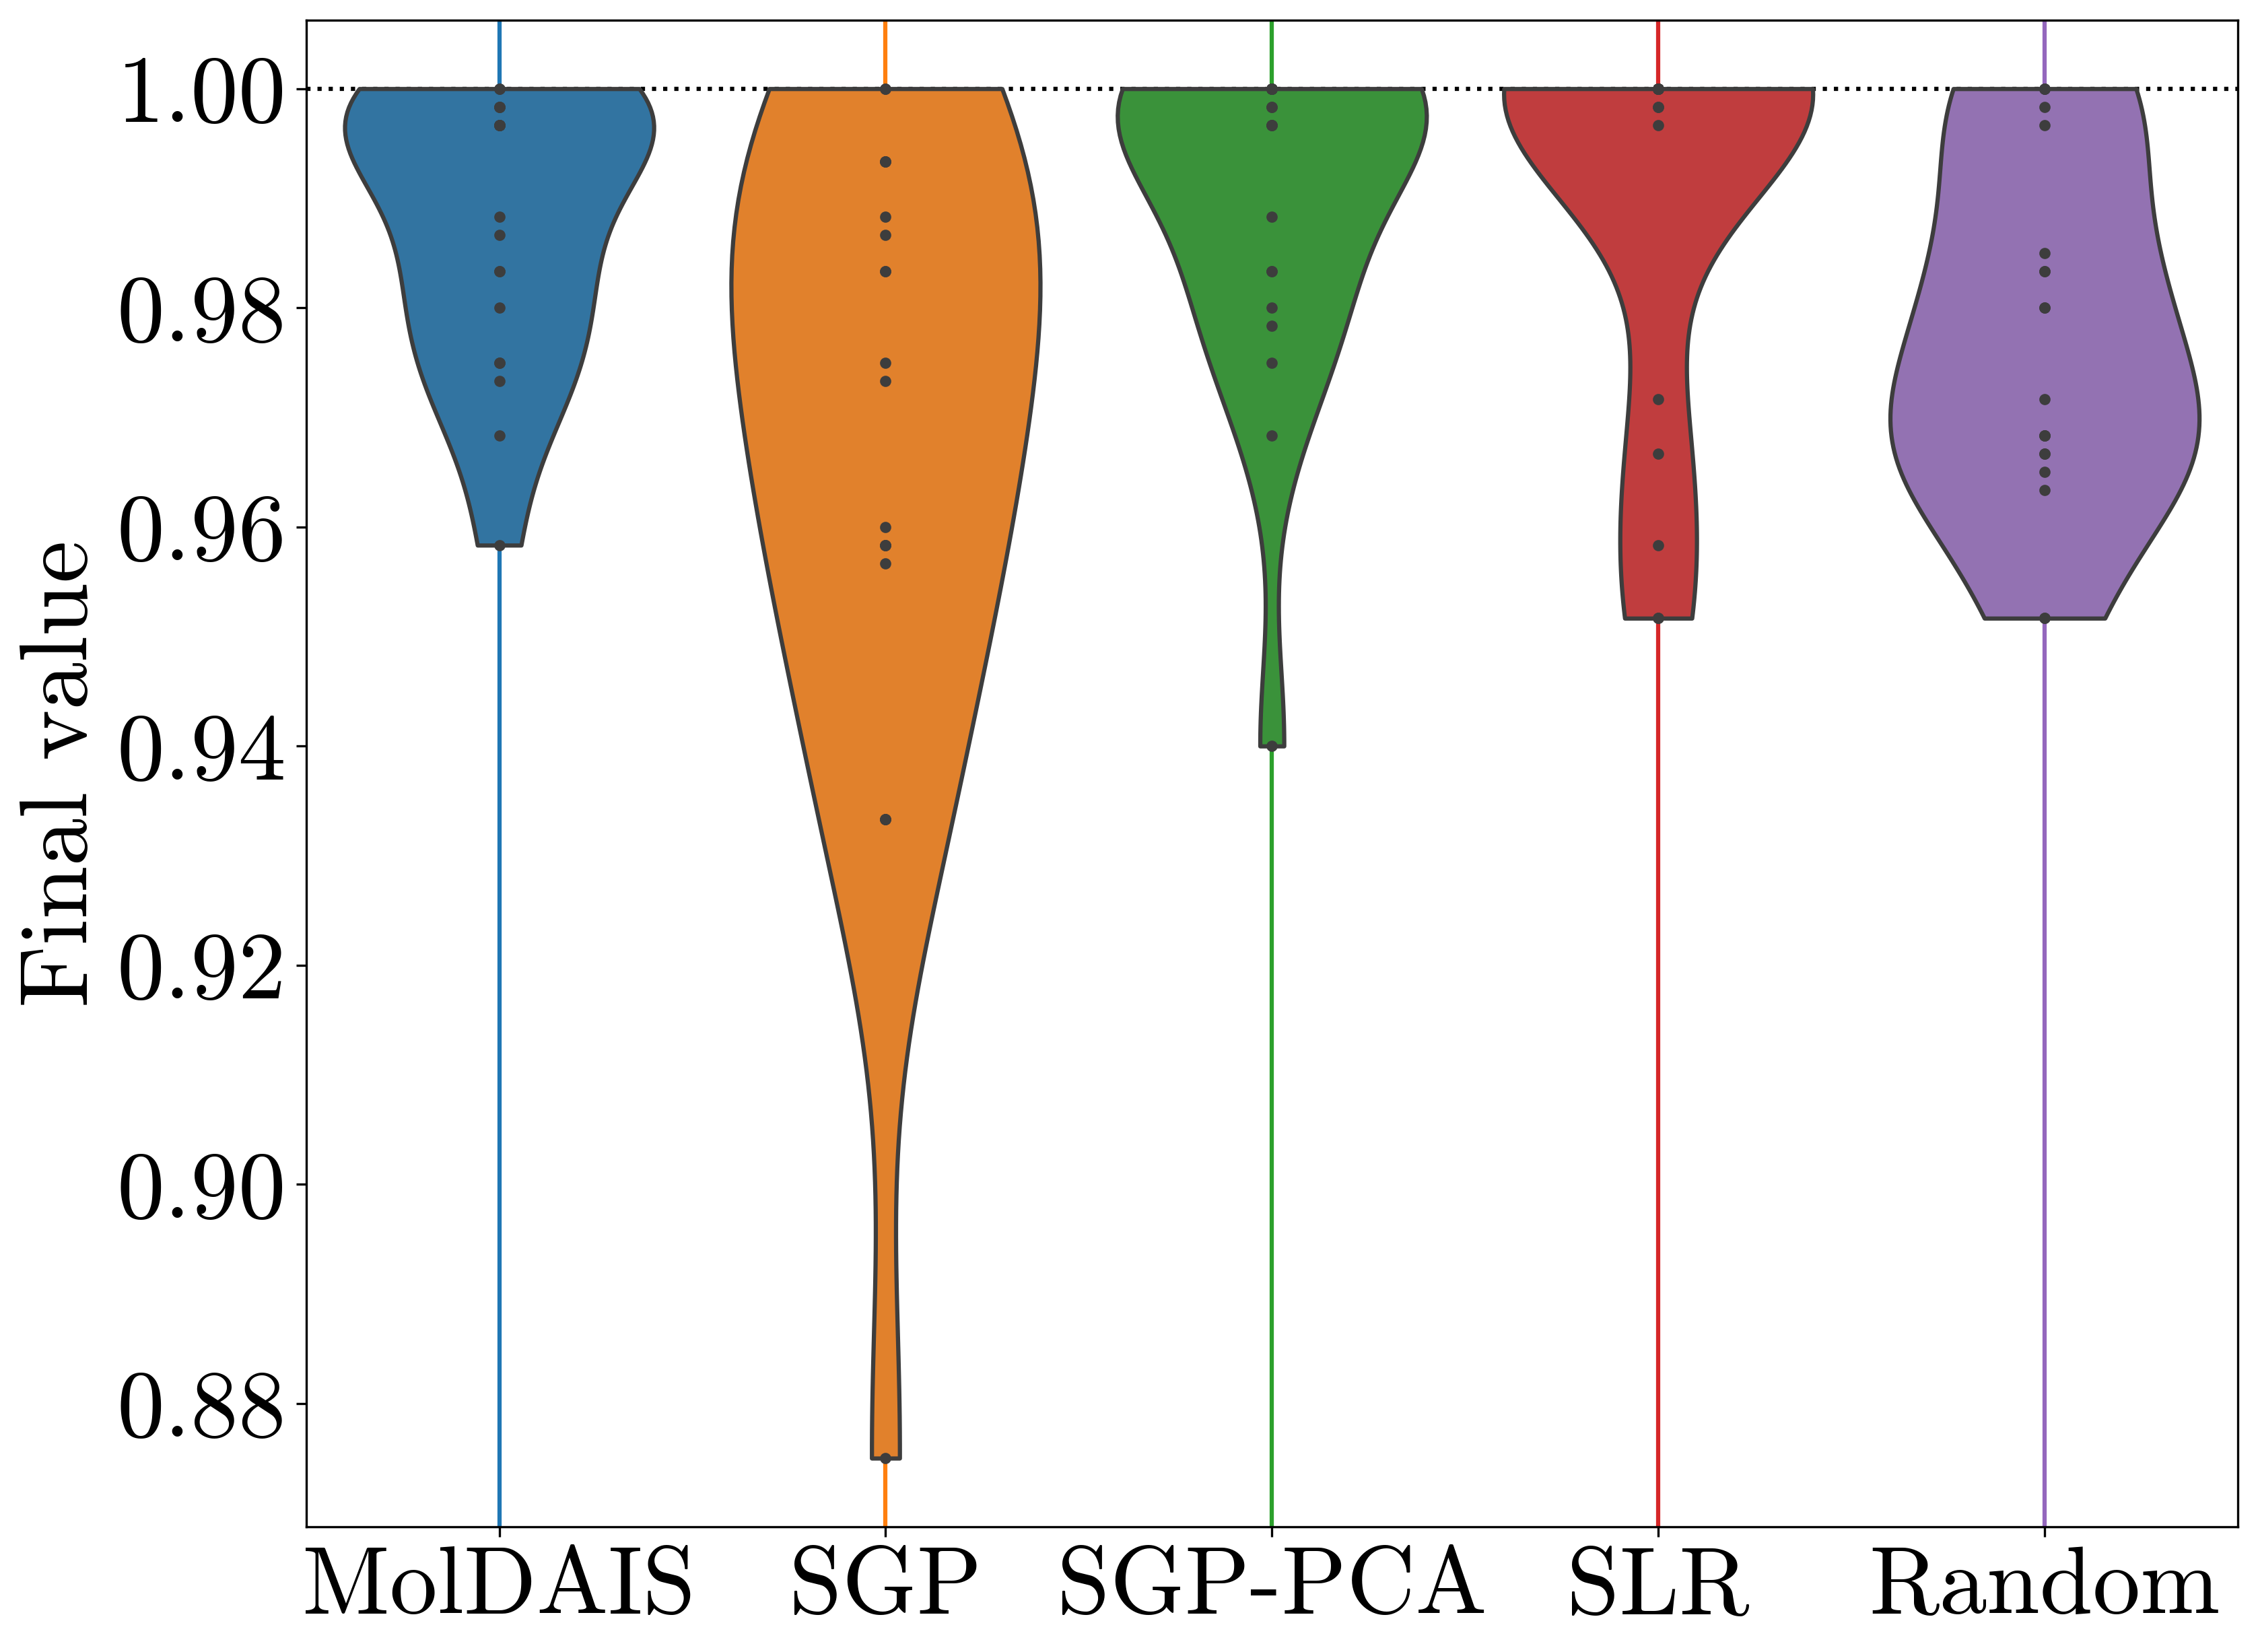

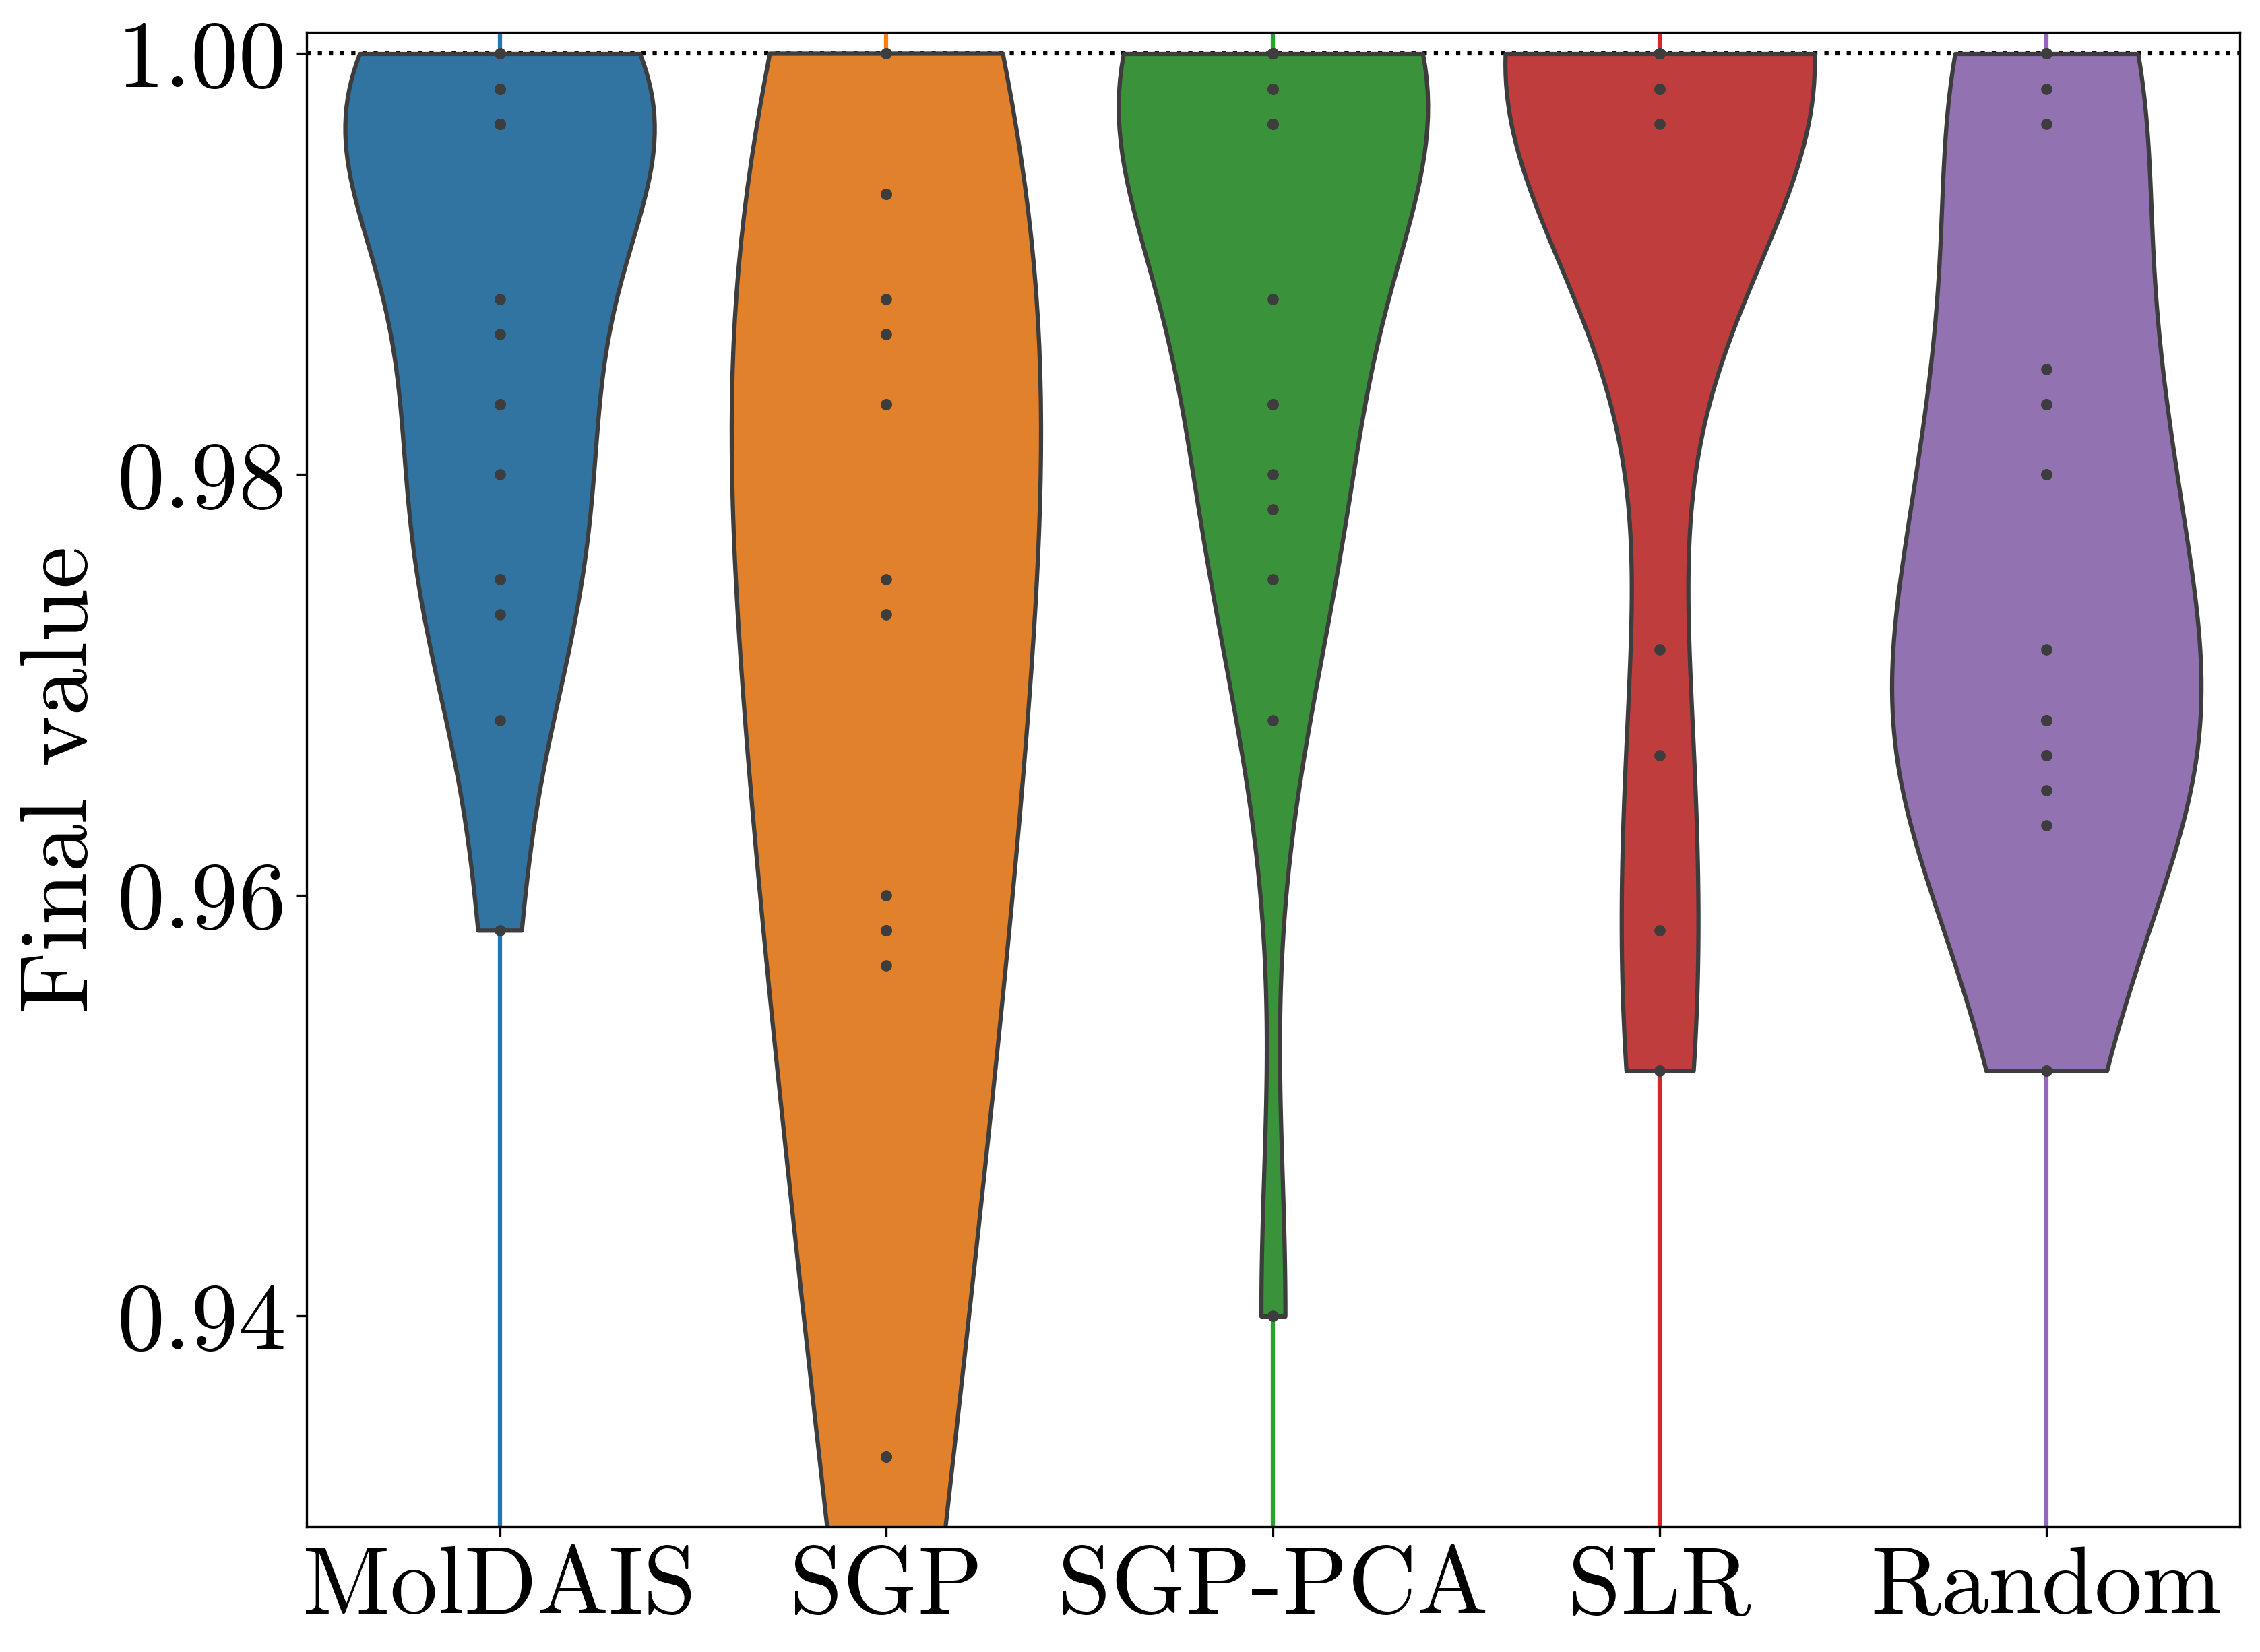

In [262]:
import pandas as pd
import seaborn as sns
sorted_results5 = Res_dict_raw['random']

end = -2
dmin = np.array(df['activity'].to_list()).min()#[df['activity']>=11.]
dmax = np.array(df['activity'].to_list()).max()#[df['activity']>=11.]


df2 = pd.DataFrame()

d =  pd.DataFrame({'Method':[names2[0]]*len(seeds), 'Final value':(sorted_results1[0,:,end]-dmin)/(dmax-dmin)})
df2 = pd.concat([df2, d])

d =  pd.DataFrame({'Method':[names2[1]]*len(seeds), 'Final value':(sorted_results2[0,:,end]-dmin)/(dmax-dmin)})
df2 = pd.concat([df2, d])

d =  pd.DataFrame({'Method':[names2[2]]*len(seeds), 'Final value':(sorted_results3[0,:,end]-dmin)/(dmax-dmin)})
df2 = pd.concat([df2, d])

d =  pd.DataFrame({'Method':[names2[3]]*len(seeds), 'Final value':(sorted_results4[0,:,end]-dmin)/(dmax-dmin)})
df2 = pd.concat([df2, d])

d =  pd.DataFrame({'Method':[names2[4]]*len(seeds), 'Final value':(sorted_results5[0,:,end]-dmin)/(dmax-dmin)})
df2 = pd.concat([df2, d])





C = [ sns.color_palette()[0], sns.color_palette()[1],
     sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[4],
     sns.color_palette()[5], sns.color_palette()[6], sns.color_palette()[6],
     sns.color_palette()[7], sns.color_palette()[8], sns.color_palette()[9],
 '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize=(12,9))
for i,ls in enumerate(range(5)):
  plt.axvline(i, color=C[i], linestyle='-', zorder=0)
plt.axhline(1,color='k', linestyle=':',zorder=0)
sns.violinplot(data=df2, x='Method', y='Final value', cut=0, inner="point", scale='width', palette=C, linestyle='dashdot')
#plt.title('Lipophilicity')
plt.xlabel(None)
#plt.ylim(.93,1.001)
#density_norm{“area”, “count”, “width”}
plt.tight_layout()
plt.savefig('./figs/lipo/finalVals.png')



plt.figure(figsize=(12,9))
for i,ls in enumerate(range(5)):
  plt.axvline(i, color=C[i], linestyle='-', zorder=0)
plt.axhline(1,color='k', linestyle=':',zorder=0)
sns.violinplot(data=df2, x='Method', y='Final value', cut=0, inner="point", scale='width', palette=C, linestyle='dashdot')
#plt.title('Lipophilicity')
plt.xlabel(None)
plt.ylim(.93,1.001)
#density_norm{“area”, “count”, “width”}
plt.tight_layout()
plt.savefig('./figs/lipo/finalVals_zoom.png')


In [508]:
df2

,SMILES,activity,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SsssP,SdsssP,SsssssP,SsSH,SdS,SssS,SaaS,SdssS,Method,Final value
0,c1cc2c3cocc3c3c4[SiH2]C(=Cc4ncc3c2[se]1)c1scc2...,3.596639,0.0,0.0,37.401219,2.609226,5.114089,37.401219,1.385230,4.314998,...,0.0,0.0,0.0,0.0,0.0,0.0,1.912631,0.0,NaN,NaN
1,C1C=Cc2ncc3c4[se]c(cc4c4=C[SiH2]C=c4c3c12)-c1c...,5.993001,0.0,0.0,34.805322,2.609043,5.113568,34.805322,1.392213,4.221130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN,NaN
2,[nH]1c(cc2c3nsnc3c3c4ccccc4oc3c12)-c1ccco1,2.855376,0.0,0.0,33.182980,2.624374,5.060910,33.182980,1.382624,4.188425,...,0.0,0.0,0.0,0.0,0.0,0.0,1.222252,0.0,NaN,NaN
3,[nH]1c2cc(-c3nccc4nsnc34)c3nsnc3c2c2ncc3cccnc3c12,7.611321,0.0,0.0,40.472742,2.607170,5.078699,40.472742,1.395612,4.372010,...,0.0,0.0,0.0,0.0,0.0,0.0,2.359574,0.0,NaN,NaN
4,[nH]1c2ccc3c[nH]cc3c2c2ccc3cc(ncc3c12)-c1scc2s...,1.471250,0.0,0.0,38.820666,2.583984,5.033398,38.820666,1.386452,4.343807,...,0.0,0.0,0.0,0.0,0.0,0.0,3.564989,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SLR,10.965166
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SLR,9.897856
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SLR,11.086613
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SLR,10.965166
